# Let's make a water table map!

### Goals:

By the end of this notebook, you should be able to:

- import and sort data from excel
- transform from latitude/longitude to cartesian grid
- create a contour map
- understand the basics of how kriging works
- create a semivariogram model and use it to interpolate between data points
- interpolate your data onto a grid and derive flux vectors from water table height and permeability values
- modify the problem and code

### Mathematical tools used:

- Coordinate system transformation
- 2D Kriging statistics
- Derivation of gradiants and fluxes


### List of software used:

- <a href="https://github.com/bsmurphy/PyKrige">PyKrige</a>, Kriging Toolkit for Python
- <a href="https://pandas.pydata.org/">Pandas</a>, Python Data Analysis Library
- <a href="http://matplotlib.org/">Matplotlib</a>, a python package used for plotting the results
- <a href="http://www.numpy.org/">Numpy</a>, a python package for linear algebra

## Before we do anything, import the necessary packages

In [2]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import pykrige
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib import cm
import numpy as np
from IPython.display import HTML
import time

from scipy.stats import norm
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import curve_fit
from scipy.sparse import diags
from scipy.linalg import block_diag
import warnings
warnings.filterwarnings('ignore')
#import sympy as sym

## Use pandas to import data from excel

In [3]:
df_wells = pd.read_excel('TOC_File_Test.xlsx', sheet_name='Well_Data')
df_river = pd.read_excel('TOC_File_Test.xlsx', sheet_name='River_Coordinates')

The data is read into our code as a Pandas dataframe. The following lines create numpy arrays from the excel columns based on the header names. The '.values' tag transforms the data from a pandas dataframe to a numpy array that is compatible with the functions we use later. <font color=red> Add in a line (line 8) to import elevation data from the 'topo_data' excel sheet - assign it to the variable 'elevation'. </font> 

*Note - we take the log10 of the permeability to make it easier and more intuitive to work with and plot. Real permeability values are so low they are in the range of machine error...*

In [4]:
x_wells = df_wells['Easting'].values
y_wells = df_wells['Northing'].values
elevation = df_wells['WL'].values

x_riv = df_river['Easting'].values
y_riv = df_river['Northing'].values



print('data type:', type(x_wells)) # check we have the right data type CHECK THIS

('data type:', <type 'numpy.ndarray'>)


### Then for the topography/head data

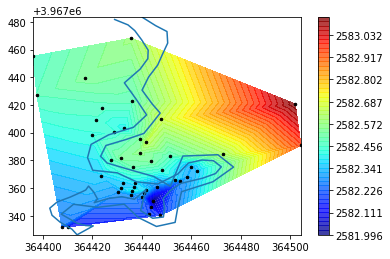

In [5]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
triang = tri.Triangulation(x_wells, y_wells)

Z = elevation
Zmin, Zmax = Z.min(), Z.max()
contour_steps = 50
levels = np.linspace(Zmin, Zmax, num = contour_steps, endpoint = True)
cpf_wells = ax1.tricontourf(triang, Z, levels, cmap = cm.jet, alpha=.75)
ax1.plot(x_wells, y_wells, '.k', ms=5)
ax1.plot(x_riv,y_riv)
fig.colorbar(cpf_wells)


fig.savefig('WTMap.png', fmt = 'png', dpi = 200)


## Build grid to interpolate both sets of data on to

Having both sets of data on the same regular grid will make it very easy to calulate fluxes and velocities

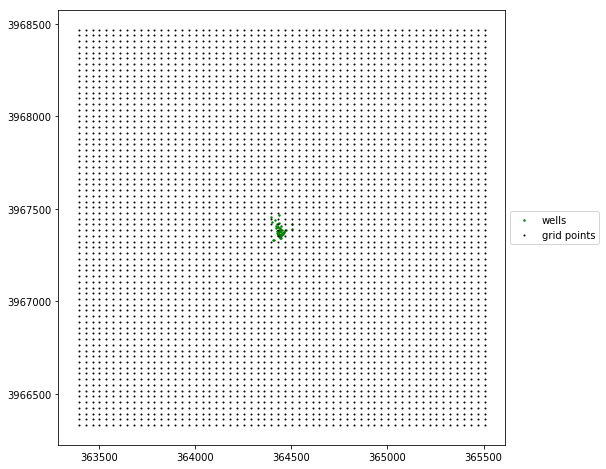

In [10]:
# Set number of increments in both x and y directions
nx, ny = (60, 70) #modify to change grid spacing
buffer = 1000 # buffer size around data points to set edge of grid (m)

x_min, x_max = x_wells.min() - buffer, x_wells.max() + buffer
y_min, y_max = y_wells.min() - buffer, y_wells.max() + buffer

x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)
x_grid, y_grid, = np.meshgrid(x, y)

#plot wells, topo/head points and grid points
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x_wells, y_wells, c='g', s=2, label='wells')
ax1.scatter(x_grid, y_grid, c='k', s=1, label='grid points')
fig.set_size_inches(8, 8)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## 2D Kriging

We use the same technique for the kriging as we did for the coordinate transformation - Build a function and then apply it to multiple datasets. The data interpolation has two main steps:

1) build a semivariogram model to fit the data (see figure below)

2) use model to interpolate from our data points onto a grid

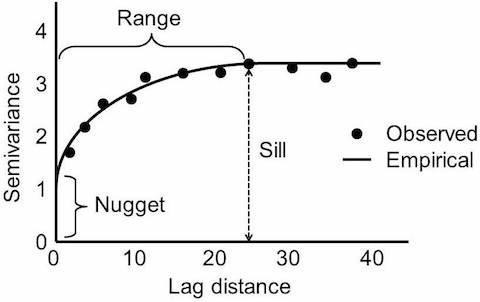

### Build functions to compute the semivariogram for the dataset and fit with variogram model and krige the data

In [14]:
def gaussian_model(x, s, r, n):
    """  Gaussian fitting curve 
    s - sill, r - range, n - nugget """
    return n + (s - n ) *(1 - np.exp(-( 3 * x**2 ) /r**2))

def exponential_model(x, s, r, n):
    """ expontential fitting curve 
    s - sill, r - range, n - nugget """
    return n + (s - n ) *(1 - np.exp(-( 3 * x ) /r))

def spherical_model(x, s, r, n):
    """ spherical fitting curve 
    s - sill, r - range, n - nugget """
    return n + (s - n) * (( 3 *x ) /( 2 *r) + np.power( x /( 2 *r), 3))

def SV_single(svdata, bin, bw, angle):
    '''
    semivariogram for a single lag range
    '''
    X, Y, Z = svdata[0], svdata[1], svdata[2]
    pdist_array = np.stack(svdata[:2], axis=1)
    rho = squareform(pdist(pdist_array, 'euclidean'))
    N = rho.shape[0]
    var_out = np.zeros((N,))
    n_var = np.zeros((N,))
    point_var = np.zeros((N,))

    for i in range(N):  # for each point
        theta_var = np.zeros(np.int(np.pi / angle), )
        ind_bin = np.where(np.abs(rho[i, :] - bin) <= bw)[0][1::]
        if len(ind_bin) > 0:
            values = Z[ind_bin]
            theta = np.arctan2(Y[ind_bin] - Y[i], X[ind_bin] - X[i])
            for j in range(0, np.int(np.pi / angle)):
                ind_theta = np.where(np.abs(theta - (-np.pi + angle + j * 2 * angle)) <= angle)[0]
                val = values[ind_theta]
                if len(val) > 0:
                    theta_var[j] = np.sum(np.power((val[:] - Z[i]), 2)) / (len(ind_theta) * 2)
            nonzero_theta = np.where(theta_var > 0)[0]
            point_var[i] = np.average(theta_var[nonzero_theta])
    nonzero = np.where(point_var > 0.0)[0]
    return np.average(point_var[nonzero])

def SV_all(svdata, bins, bws, angle):
    '''
    variogram for a collection of lags
    '''
    sv = list()
    count=0
    for bin in bins:
        sv.append(SV_single(svdata, bin, bws[count], angle))
        count += 1
    sv = [[bins[i], sv[i]] for i in range(len(bins)) if sv[i] > 0]
    return np.array(sv).T

def semivariogram(svdata, bandwidth, max_h, initial_guess):

    bw = bandwidth  # bandwidth of bins
    max = max_h # max distance to calculate semivariance of data
    svtheta = np.pi/4   # bin angle in radians
    ntime = max/(bw*2)
    bands = np.repeat(2*bw, ntime)
    bins = np.cumsum(bands)
    sv = SV_all(svdata, bins, bands, svtheta)
    srn_exp, cov_exp = curve_fit(exponential_model, sv[0], sv[1], p0 = initial_guess)
    srn_sp, cov_sp = curve_fit(spherical_model, sv[0], sv[1], p0 = initial_guess)
    srn_gauss, cov_gauss = curve_fit(gaussian_model, sv[0], sv[1], p0 = initial_guess)
    print ("Exponential model - sill = {0}, range = {1}, nugget = {2}".
            format(round(srn_exp[0],2), round(srn_exp[1],2), round(srn_exp[2],2)))
    print ("Spherical model - sill = {0}, range = {1}, nugget = {2}".
            format(round(srn_sp[0],2), round(srn_sp[1],2), round(srn_sp[2],2)))
    print ("Gaussian model - sill = {0}, range = {1}, nugget = {2}".
            format(round(srn_gauss[0],2), round(srn_gauss[1],2), round(srn_gauss[2],2)))
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.plot(sv[0], sv[1], '.', label = 'Data')
    fit = ax2.plot(sv[0], exponential_model(sv[0], *srn_exp), "--", label = "Exponential model")
    fit2 = ax2.plot(sv[0], spherical_model(sv[0], *srn_sp), "--", label = "Spherical model")
    fit3 = ax2.plot(sv[0], gaussian_model(sv[0], *srn_sp), "--", label = "Gaussian model")
    plt.xlim(0, max)
    plt.xlabel('Lag [m]')
    plt.ylabel('Semivariance')
    plt.title('Semivariogram')
    plt.legend(loc = 'upper left')  
    return srn_exp, srn_sp, srn_gauss

def kriging2D(x_data, y_data, z_data, x_output, y_output, model_type, model_parameters):
    """Interpolates 2D permeability data by kriging from excel file
        INPUTS:
            [x_data] = array or list - x coordinates of data points
            [y_data] = array or list - y coordinates of data points
            [z_data] = array or list of variable values at the data points (permeability or elevation)
            [x_output] = array or list of X grid values to interpolate on to
            [y_output] = array or list of Y grid values to interpolate on to
            [model_type] = string of one of the following variogram models used to interpolate the data
            [model_parameters] = list of necessary parameters for the given model

            OrdinaryKriging function takes variogram parameters for each model type as:
                linear - [slope, nugget]
                power - [scale, exponent, nugget]
                gaussian - [sill, range, nugget]
                spherical - [sill, range, nugget]
                exponential - [sill, range, nugget]
                hole-effect - [sill, range, nugget]

        OUPUTS:
            variable_grid - the interpolated variable on the specified grid 
    """
    #build the Kriging function from the given data
    OK = OrdinaryKriging(x_data, y_data, z_data, variogram_model=model_type,
                         variogram_parameters=model_parameters)
    
    #Use function 'OK' to interpolate varibale onto grid
    z_grid, ss = OK.execute('grid', x_output, y_output)

    #return a numpy array of the interpolated values
    return z_grid.compressed(), ss.compressed()


## Topo/Head data
### Provide data, initial parameter guess, bin width and max distance to calculate semivariogram

<font color=red>Change the *bandwidth* and the *max_h* values and see what happens to the model!</font>

In [16]:
svdata = [x_wells, y_wells, elevation] #data to calculate semivariogram
initial_guess = (5e5, 5e4, 1e2) # (sill, range, nugget)
bandwidth = 2e3 # width of bins in meters
max_h = 100e3 # max lag distance from each point (meters)

# Calculate 3 different fitting models using 'semivariogram' function
srn_exp_elev, srn_sph_elev, srn_gauss_elev = semivariogram(svdata, bandwidth, max_h, initial_guess)

TypeError: Improper input: N=3 must not exceed M=1

### Pick best model and run kriging function - Topography/head

<font color=red>Decide which of the 3 models above best captures the data and use it to interpolate the dataset onto the fixed grid. See what happens when you us one model vs another!</font>

Min/Max value: -325.8168157212095 2695.6767571195887


(-75785.62160498057,
 29599.384658466803,
 118998.33494211557,
 272790.33873475285)

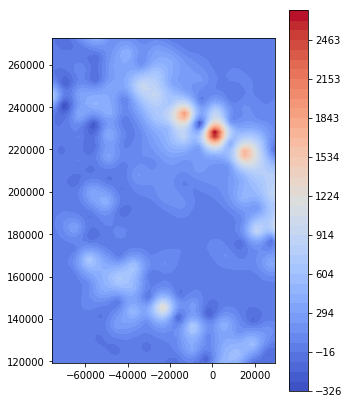

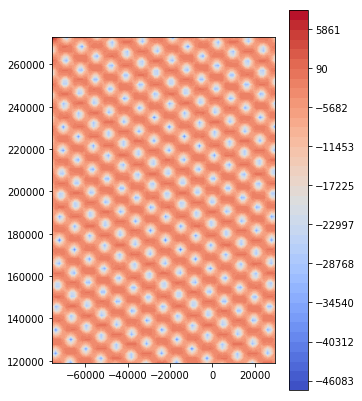

In [11]:
# change both model type and model parameters to match chosen model type
model_type = 'exponential'
model_parameters = srn_exp_elev.tolist() # options are:  srn_exp_elev, srn_sph_elev, srn_gauss_elev

topo_grid, toposs_grid = kriging2D(x_topo, y_topo, elevation, x, y, model_type, model_parameters)
topo_grid, toposs_grid = topo_grid.reshape(ny,nx), toposs_grid.reshape(ny,nx)
print ("Min/Max value:",topo_grid.min(), topo_grid.max())

#make figures
fig = plt.figure(figsize=(5,7))
ax1 = fig.add_subplot(111)
contour_steps = 40
levels = np.linspace(topo_grid.min(), topo_grid.max(), num = contour_steps, endpoint = True)
cpf = ax1.contourf(x_grid, y_grid, topo_grid, levels, cmap = cm.coolwarm)
fig.colorbar(cpf)
plt.axis('scaled')

fig2 = plt.figure(figsize=(5,7))
ax2 = fig2.add_subplot(111)
contour_steps = 40
levelss = np.linspace(toposs_grid.min(), toposs_grid.max(), num = contour_steps, endpoint = True)
cpfss = ax2.contourf(x_grid, y_grid, toposs_grid, levelss, cmap = cm.coolwarm)
fig2.colorbar(cpfss)
plt.axis('scaled')

## Permeability data
### Provide data, initial parameter guess, bin width and max distance to calculate semivariogram

In [17]:
svdata = [x_wells, y_wells, logk]
initial_guess = (1, 10e3, 0)
bandwidth = .25e3
max_h = 10e3

# Run semivariogram function with our chosen parameters
srn_exp_k, srn_sph_k, srn_gauss_k = semivariogram(svdata, bandwidth, max_h, initial_guess)

NameError: name 'logk' is not defined

### Pick best model and run kriging function

Min/Max value: -13.090431933443881 -10.562017631244


(-75785.62160498057,
 29599.384658466803,
 118998.33494211557,
 272790.33873475285)

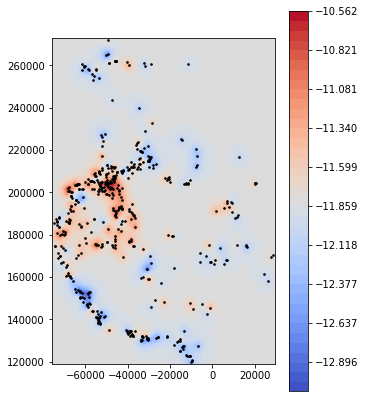

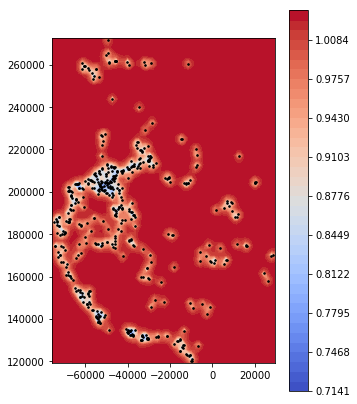

In [14]:
# change both model type and model parameters to match chosen model type
model_type = 'exponential'
model_parameters = srn_exp_k.tolist() # srn_exp_k, srn_sph_k, srn_gauss_k

logk_grid, kss_grid = kriging2D(x_wells, y_wells, logk, x, y, model_type, model_parameters)
logk_grid, kss_grid = logk_grid.reshape(ny,nx), kss_grid.reshape(ny,nx)
print ("Min/Max value:",logk_grid.min(), logk_grid.max())

# plot intepolated data field
fig = plt.figure(figsize=(5,7))
ax1 = fig.add_subplot(111)
contour_steps = 40
levels = np.linspace(logk_grid.min(), logk_grid.max(), num = contour_steps, endpoint = True)
cpf = ax1.contourf(x_grid, y_grid, logk_grid, levels, cmap = cm.coolwarm)
#cp = ax1.contour(x_grid, y_grid, logk_grid, levels, linewidth=1, colors = 'black', linestyles = 'solid')
wells = ax1.scatter(x_wells, y_wells, marker= ".", s = 10, facecolors='black')
fig.colorbar(cpf)
plt.axis('scaled')
#fig.savefig('kriging_map.png', fmt = 'png', dpi = 200)

# plot variance map
fig2 = plt.figure(figsize=(5,7))
ax2 = fig2.add_subplot(111)
contour_steps = 40
levelss = np.linspace(kss_grid.min(), kss_grid.max(), num = contour_steps, endpoint = True)
cpfss = ax2.contourf(x_grid, y_grid, kss_grid, levelss, cmap = cm.coolwarm)
wells = ax2.scatter(x_wells, y_wells, marker= ".", s = 10, facecolors='black')
fig2.colorbar(cpfss)
plt.axis('scaled')

## Now we have our permeability and topo/head data interpolated onto the same grid - let's calculate fluxes

### But first... we need to calculate hydraulic conductivity and head gradients

The equation for a linear flux velocity (or Darcy flux), $q$, is:

$$ q= -K\frac{dh}{dx}$$

where $K$ is the hydraulic conductivity in $\frac{m}{s}$ and $\frac{dh}{dx}$ is the head gradient. $K$ is related to permeability, $\kappa$, by:

$$ K = \frac{\rho g}{\mu} \kappa $$

$\kappa$  is the permeability in $m^2$, $\mu$  is the dynamic viscosity of the fluid in $\frac{kg}{m·s}$, $\rho$  is the density of the fluid in $\frac{kg}{m^3}$, and $g$ is the acceleration due to gravity in $\frac{m}{s^2}$.

<font color=red>Put in approporiate values for rho ($\rho$) and mu ($\mu$)</font>

*Note - we moved permeability into log10 space when we imported it, now we move it back out of log space to calculate fluxes. If we didn't, we would have physically impossible negative permeability values (line 5)*


minimum conductivity:  7.957820563393911e-07
maximum conductivity:  0.0002686633615829343
Are these reasonable values?


(-75785.62160498057,
 29599.384658466803,
 118998.33494211557,
 272790.33873475285)

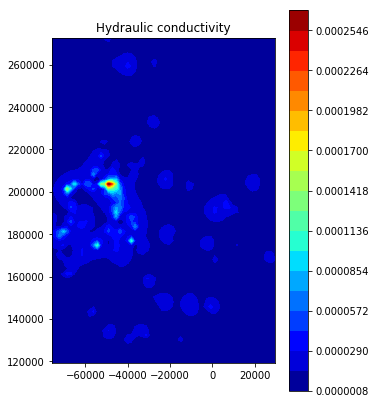

In [27]:
rho = 1000 # density of water in kg/m^3
g = 9.8 # gravity  m/s^2
mu = 1e-3 # viscosity of water in Pa or kg/ms^2

K = ((rho*g)/mu) * np.power(10, logk_grid)
print ('minimum conductivity: ', K.min())
print ('maximum conductivity: ', K.max())
print ('Are these reasonable values?')

fig = plt.figure(figsize=(5,7))
contour_steps = 20
levels = np.linspace(K.min(), K.max(), num = contour_steps, endpoint = True)
Kplot = plt.contourf(x_grid,y_grid, K, levels, cmap = cm.jet)
fig.colorbar(Kplot)
plt.title('Hydraulic conductivity')
plt.axis('scaled')

### Get head gradient at each grid point

We will calculate fluxes in both the x and y directions separately. Here you can see why interpolating onto a regular grid is nice - the $dx$ in the flux equation is constant. Remember that the derivative (or gradient) is just the slope of a value - in this case head. To calculate the head gradient in each direction, we will use the central difference formula:

$$ \frac{dh_i}{dx} = \frac{h_{i+1} - h_{i-1}}{2dx} $$

So, to find the gradient in the x-direction at each grid point, we take the head value at the next grid point (to the right) minus the value at the previous grid point (to the left) and divide by twice the grid spacing. We do the same thing in the y direction, but instead moving up and down. <font color=red>Where might this method be a problem?</font>

min/max dhdx:  -0.31293404755265736 0.37048744986182724
min/max dhdy:  -0.31855321708169354 0.3075854825315383


(-75785.62160498057,
 29599.384658466803,
 118998.33494211557,
 272790.33873475285)

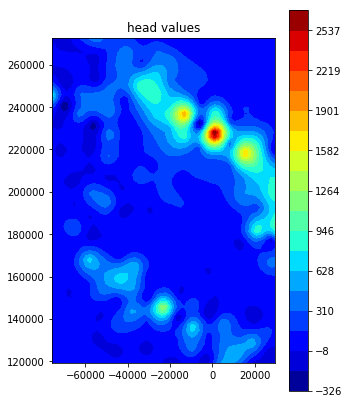

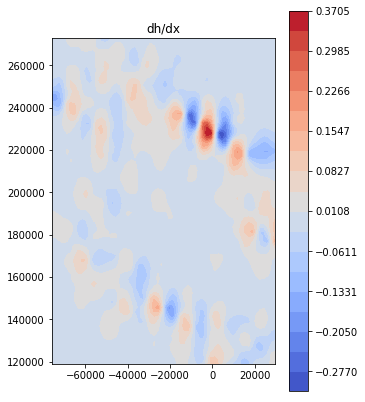

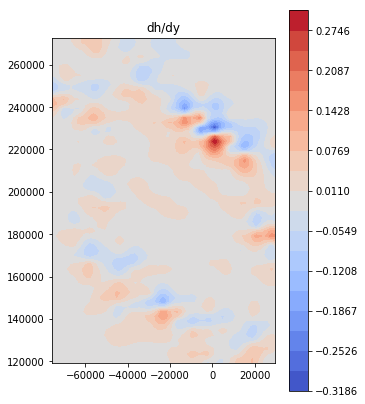

In [15]:
gridx_min, gridx_max = x_min, x_max
gridy_min, gridy_max = y_min, y_max

nx_flux, ny_flux = (nx, ny)
minx, maxx = gridx_min, gridx_max
miny, maxy = gridy_min, gridy_max
dx, dy = (maxx - minx)/(nx_flux-1), (maxy - miny)/(ny_flux-1)

xflux = np.linspace(minx, maxx, nx_flux)
yflux = np.linspace(miny, maxy, ny_flux)
xx, yy = np.meshgrid(xflux, yflux, sparse=False)

hgrid = topo_grid
hvec = hgrid.reshape(nx_flux*ny_flux,)

# build block matrix for d/dx
diag_t = np.hstack([2.,np.ones(nx_flux-2)])
diag_c = np.hstack([-2, np.zeros(nx_flux-2), 2])
diag_b = np.hstack([-1*np.ones(nx_flux-2), -2])
diagonals = [diag_t, diag_c, diag_b]
diff_block = diags(diagonals, [1, 0, -1]).todense()
bdiag = [diff_block]*ny_flux

# place blocks along diagonal to build d/dx matrix
diffx_matrix = (1/(2*dx))*block_diag(*bdiag)

# build d/dy matrix
diag_ty = np.hstack([2*np.ones(nx_flux), np.ones(nx_flux*(ny_flux-2))])
diag_cy = np.hstack([-2*np.ones(nx_flux), np.zeros(nx_flux*(ny_flux-2)), 2*np.ones(nx_flux)])
diag_by = np.hstack([-1*np.ones(nx_flux*(ny_flux-2)), -2*np.ones(nx_flux)])
diagonals_y = [diag_ty, diag_cy, diag_by]

# place diagonals to build d/dy
diffy_matrix = (1/(2*dy))*diags(diagonals_y, [nx, 0, -nx]).todense()

dhdx, dhdy = np.matmul(diffx_matrix, hvec), np.matmul(diffy_matrix, hvec)
dhdxgrid, dhdygrid = dhdx.reshape(ny_flux,nx_flux), np.asarray(dhdy.reshape(ny_flux,nx_flux))
print('min/max dhdx: ', dhdx.min(), dhdx.max())
print('min/max dhdy: ', dhdy.min(), dhdy.max())

# plot head and gradient maps
fig = plt.figure(figsize=(5,7))
contour_steps = 20
levels = np.linspace(hgrid.min(), hgrid.max(), num = contour_steps, endpoint = True)
h = plt.contourf(xx,yy,hgrid, levels, cmap = cm.jet)
fig.colorbar(h)
plt.title('head values')
plt.axis('scaled')

fig2 = plt.figure(figsize=(5,7))
contour_steps = 20
levels = np.linspace(dhdxgrid.min(), dhdxgrid.max(), num = contour_steps, endpoint = True)
dhxplot = plt.contourf(xx,yy,dhdxgrid, levels, cmap = cm.coolwarm)
fig2.colorbar(dhxplot)
plt.title('dh/dx')
plt.axis('scaled')

fig3 = plt.figure(figsize=(5,7))
contour_steps = 20
levels = np.linspace(dhdygrid.min(), dhdygrid.max(), num = contour_steps, endpoint = True)
dhyplot = plt.contourf(xx, yy, dhdygrid, levels, cmap = cm.coolwarm)
fig3.colorbar(dhyplot)
plt.title('dh/dy')
plt.axis('scaled')


### Okay, now we can calculate fluxes in both directions!!

In [16]:
# q = -K*(dh/dx)
flux_x = -1*np.multiply(K, dhdxgrid)
flux_y = -1*np.multiply(K, dhdygrid)
print('min/max flux x: ', flux_x.min(), flux_x.max())
print('min/max flux y: ', flux_y.min(), flux_y.max())


# plot flux maps
fig = plt.figure(figsize=(5,7))
contour_steps = 20
levels = np.linspace(-.7e-6, .7e-6, num = contour_steps, endpoint = True)
qxplot = plt.contourf(xx, yy, flux_x, levels, cmap = cm.coolwarm)
fig.colorbar(qxplot)
plt.title('qx')
plt.axis('scaled')

fig2 = plt.figure(figsize=(5,7))
contour_steps = 20
levels = np.linspace(-.7e-6, .7e-6, num = contour_steps, endpoint = True)
qyplot = plt.contourf(xx, yy, flux_y, levels, cmap = cm.coolwarm)
fig2.colorbar(qyplot)
plt.title('qy')
plt.axis('scaled')

# plot head with flux vectors
fig = plt.figure(figsize=(5,7))
contour_steps = 20
levels = np.linspace(hgrid.min(), hgrid.max(), num = contour_steps, endpoint = True)
h = plt.contourf(xx,yy,hgrid, levels, cmap = cm.jet, alpha = .4)
fig.colorbar(h)
plt.title('head values w/ flux vectors')
plt.axis('scaled')
skip = 5
plt.quiver(xx[::skip,::skip], yy[::skip,::skip], flux_x[::skip,::skip], flux_y[::skip,::skip], 
           color = 'black', width=5e-3)#, scale=5e3)

NameError: name 'K' is not defined